# Managing Randomness in Experiments

In [1]:
import os
import torch
import random
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, zero_one_loss
)

from dataclasses import dataclass

from eleven.vis import plot_confusion_matrix
from eleven.data import create_boston_classification

In [2]:
mpl.style.use('fivethirtyeight')

# Holding Random State in a Class

I typically write a class that manages the various random states used in my experiments.

In [3]:
@dataclass
class Seeds:
    pythonhash: int = 0
    pythonrand: int = 0
    numpy: int = 0
    torch: int = 0


class SeedControl:
    """Manage random seeds
    
    This can be used directly or as a 
    context manager.
    """

    def __init__(self, seeds=Seeds()):
        self.s = seeds
        
    def __enter__(self):
        self.set_seeds()
        
    def __exit__(self, exc_type, exc_val, traceback):
        pass

    def update_all_seeds(self, seed: int):
        """Fix all seeds to the same seed"""
        self.s = Seeds(
            pythonhash=seed, 
            pythonrand=seed, 
            numpy=seed, 
            torch=seed
        )
        
        self.set_seeds()

    def set_seeds(self):
        """Set the random seeds in the environement"""
        os.environ['PYTHONHASHSEED'] = str(self.s.pythonhash)
        random.seed(self.s.pythonrand)
        np.random.seed(self.s.numpy)
        torch.manual_seed(self.s.torch)

    def get_seeds(self):
        return {
            'PythonHash': self.s.pythonhash,
            'PythonRand': self.s.pythonrand,
            'Numpy': self.s.numpy,
            'Torch': self.s.torch
        }

In [4]:
def print_random_states():
    """"""
    numpy_state = np.random.get_state()[1][0]
    torch_state = torch.random.initial_seed()
    python_hash_state = os.environ['PYTHONHASHSEED']
    
    print(f"Numpy's random state: {numpy_state}")
    print(f"Pytorch's random state: {torch_state}")
    print(f"Python's environment state: {python_hash_state}")

In [5]:
# Using SeedControl directly
seed_control = SeedControl()

In [6]:
seed_control.get_seeds()

{'PythonHash': 0, 'PythonRand': 0, 'Numpy': 0, 'Torch': 0}

In [7]:
seed_control.set_seeds()
print_random_states()

Numpy's random state: 0
Pytorch's random state: 0
Python's environment state: 0


In [8]:
seed_control.update_all_seeds(10)

In [9]:
seed_control.get_seeds()

{'PythonHash': 10, 'PythonRand': 10, 'Numpy': 10, 'Torch': 10}

In [10]:
print_random_states()

Numpy's random state: 10
Pytorch's random state: 10
Python's environment state: 10


## A Note on Setting Seeds

Setting a seed does not mean that all subsequent calls that require randomness will be fixed the same value! The seed sets a psuedorandom state for sequences of random numbers. Check this out:

In [11]:
seed_control = SeedControl()

In [12]:
with SeedControl(): 
    print('1st random number = ', random.random())
    print('2nd random number = ', random.random())
    print('1st random int = ', random.randint(1, 100))
    print('2nd random int = ', random.randint(1, 100))

1st random number =  0.8444218515250481
2nd random number =  0.7579544029403025
1st random int =  54
2nd random int =  6


In [13]:
# Get us back to our starting point by resetting the random seeds
with SeedControl():
    print('\n3rd random number = ', random.random())
    print('4th random number = ', random.random())
    print('3rd random int = ', random.randint(1, 100))
    print('4th random int = ', random.randint(1, 100))


3rd random number =  0.8444218515250481
4th random number =  0.7579544029403025
3rd random int =  54
4th random int =  6


In [14]:
# Update Python's random seed to 1 (default is 0)
with SeedControl(Seeds(pythonrand=1)):
    print('\n3rd random number = ', random.random())
    print('4th random number = ', random.random())
    print('3rd random int = ', random.randint(1, 100))
    print('4th random int = ', random.randint(1, 100))


3rd random number =  0.13436424411240122
4th random number =  0.8474337369372327
3rd random int =  98
4th random int =  9


# Cross Validation for Variation in our Data

In [15]:
boston_x, boston_y = create_boston_classification()

x_train, x_test, y_train, y_test = train_test_split(
    boston_x, boston_y, test_size=0.33, random_state=42
)

In [16]:
@dataclass
class Hparams:
    """Hyperparameters for our models"""
    max_depth: int = 1
    min_samples_leaf: int = 1
    n_estimators: int = 400
    learning_rate: float = 1.0

hparams = Hparams()
        
classifier = AdaBoostClassifier(
    learning_rate=hparams.learning_rate,
    n_estimators=hparams.n_estimators,
    algorithm="SAMME",
)

In [17]:
scores = cross_val_score(
    classifier, x_train, y_train, cv=5, scoring='accuracy'
)

In [18]:
print(f"Accuracy over each of the folds:\n\t{scores}")

Accuracy over each of the folds:
	[0.75       0.76470588 0.75       0.79411765 0.7761194 ]


# A Slight Modification & ROC Curves

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

I am going to simplify our classification problem here a bit. Let's make this a binary classification, where we keep only the labels 0 and 1. Then, let's take a look at how our ROC curves respond to variation within our training data. Using 5 fold cross-validation, we will calculate the mean area under the curve, and see the variance of the curve when the training set is split into different subsets. This gives us an idea of how much our classifier is affected by different samples of our training data.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [19]:
X_arry, y_arry = boston_x.values, boston_y.values

In [20]:
# Make this a binary classification problem real quick
X, y = X_arry[y_arry != 2], y_arry[y_arry != 2]

n_samples, n_features = X.shape

# Take a look at the docs on how to setup stratified
# k-fold cross validation here!
cv = StratifiedKFold(n_splits=5)

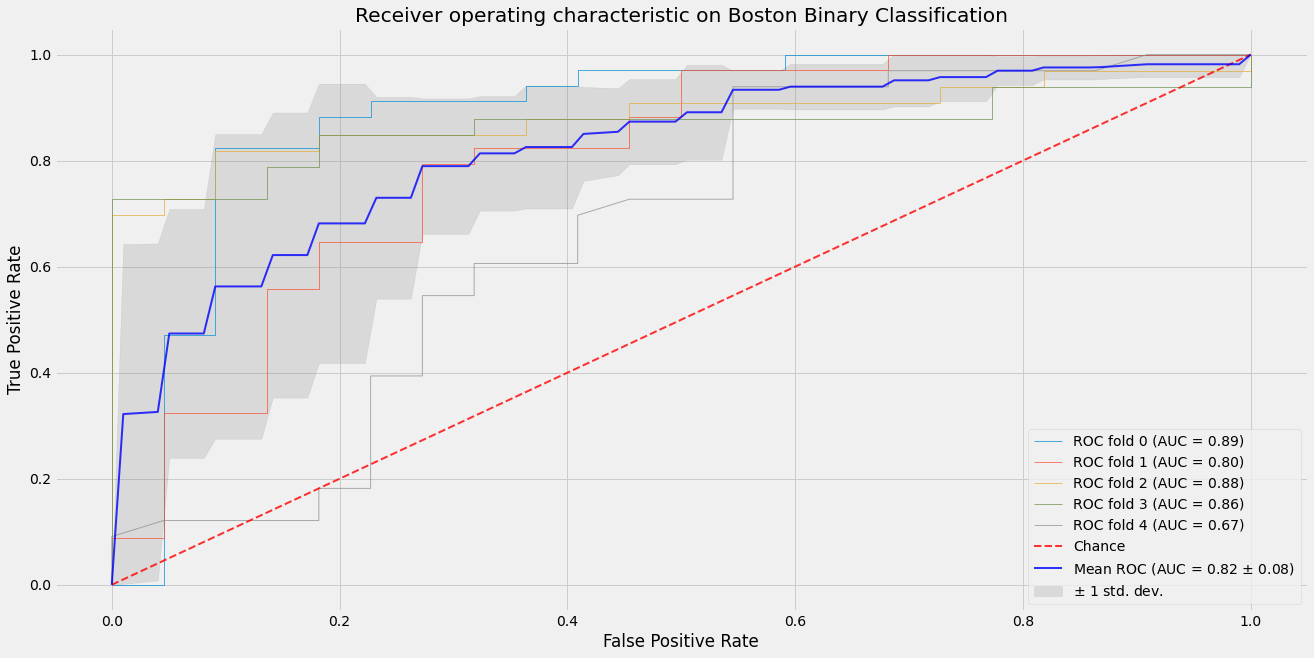

In [21]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(20,10))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    
    viz = plot_roc_curve(
        classifier, X[test], y[test],
        name='ROC fold {}'.format(i),
        alpha=0.7, lw=1, ax=ax
    )
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic on Boston Binary Classification")
ax.legend(loc="lower right")
plt.show()